# Planet torque

## Subject of the exercise

In this exercise we will simulate the torque of a planet in Type 1 migration.

We compare against the linear Lindblad torque ([Paardekooper et al. 2011](https://ui.adsabs.harvard.edu/abs/2011MNRAS.416L..65P/abstract), Eq. (14))
\begin{align}
\frac{\Gamma_\mathrm{L}}{\Gamma_0} = - \frac{1}{\gamma} \left( 2.5 + 1.7 \beta - 0.1 \alpha \right) \left( \frac{0.4}{b/h} \right)\,,
\end{align}
with the adiabatic index $\gamma$, $\beta = \frac{\mathrm{dlog}T}{\mathrm{dlog}r}$, $\alpha = \frac{\mathrm{dlog}\Sigma}{\mathrm{dlog}r}$, aspect ratio $h$, and the smoothing length factor $b = r_\mathrm{sm}/r$.
The torque normalization is $\Gamma_0 = (q/h)^2 \Sigma_p r_p^4 \Omega_p^2$ with the planet to star mass ratio $q$, the surface density at the planet location $\Sigma_p$, the planetary orbital radius $r_p$ and the planetary orbital angular velocity $\Omega_p$.


# Change directory

In [1]:
example_name = "Type1Torques"
!mkdir -p $example_name
import os
os.chdir(example_name)

## Setup

We'll take the example setup file from the examples directory and modify it in python.

In [2]:
# make a copy of the default file

src_config = "../../type1.yml"

import ruamel.yaml
yaml = ruamel.yaml.YAML()

config_file = f"setup_ref.yml"

with open(src_config, "r") as infile:
    config = yaml.load(infile)

config["nbody"][1]["mass"] = 2e-5
config["DT"] = 0.314 # monitor scalar files around every half orbit
config["Ninterm"] = 20 # write a snapshot every orbit
config["Ntot"] = 100 # wirte 100 snapshots
# use very low resolution by setting it to 2 cell per scaleheight, cps
config["cps"] = 2

config["OutputDir"] = f"output/refsim"


# write the file to disk
with open(config_file, "w") as outfile:
    yaml.dump(config, outfile)

## Running the code

In [3]:
cwd = os.getcwd()
cmd = f"cd {cwd} && run_fargo -np 1 -nt 4 auto {config_file}"
print(cmd)

cd /home/thomas/repo/spp1992-fargo-tutorial/notebooks/Type1Torques && run_fargo -np 1 -nt 4 auto setup_ref.yml


## Plotting the torque

alpha 1.5
beta 1
q 2e-05
h 0.05
SigmaP 0.000376
OmegaP 1
b 0.020000000000000004
expected torque -4.049999999999999
output/refsim


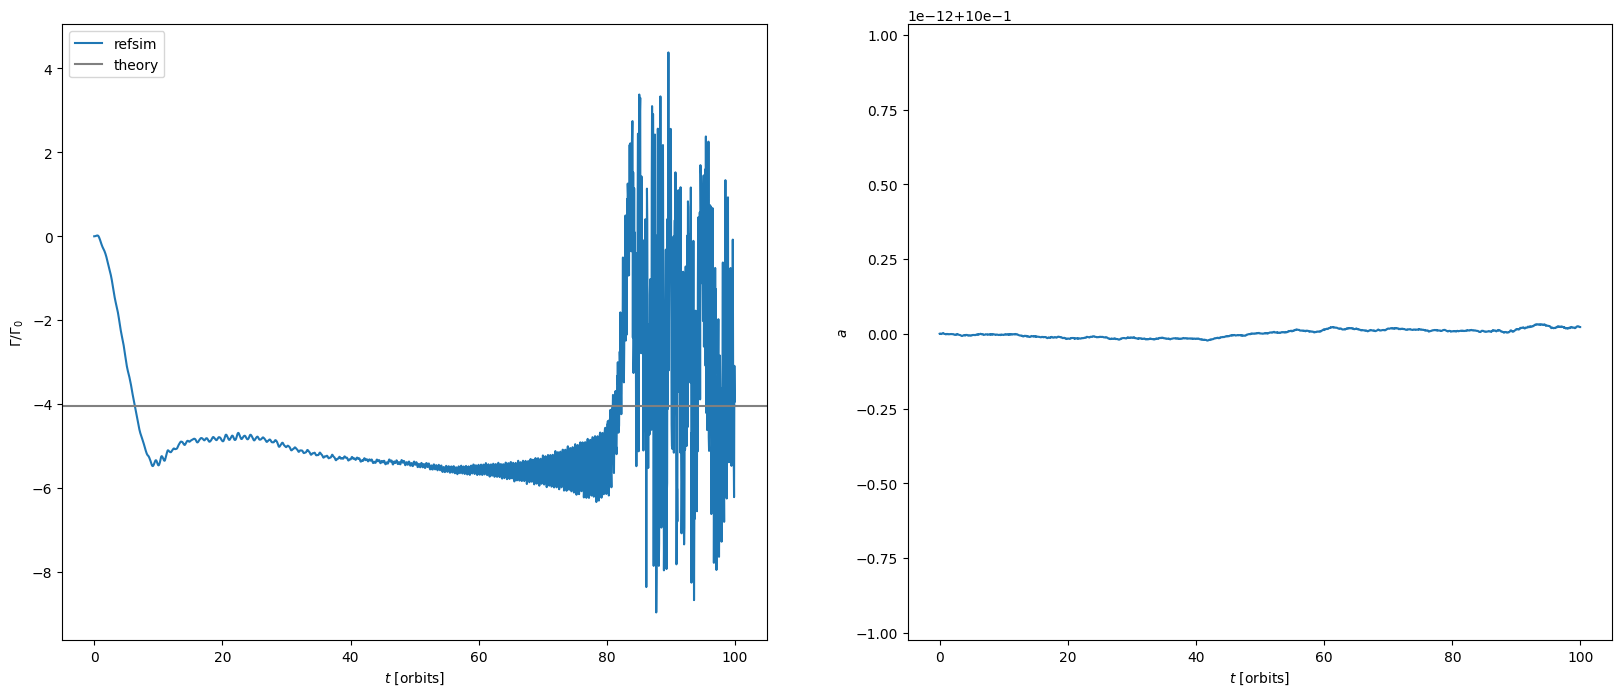

In [4]:

import matplotlib.pyplot as plt
import numpy as np
import yaml
with open("setup_ref.yml", "r") as infile:
    params = yaml.safe_load(infile)

alpha = params["SigmaSlope"] #1.5 # - surface density power law index
flaringindex = params["FlaringIndex"]
beta = 1-2*flaringindex #1 # - temperature power law index
q = float(params["nbody"][1]["mass"])/float(params["nbody"][0]["mass"]) #2e-5 # reduced planet mass
h = params["AspectRatio"]#0.05 # aspect ratio
SigmaP = 3.76e-4 # Surface density at planet location
OmegaP = 1#2*np.pi
b = h*params["ThicknessSmoothing"] #0.4*h # smoothing lenght factor

Gamma0 = (q/h)**2 * SigmaP * OmegaP**2
# Paardekooper et al 2009

expected_torque = -(2.5 + 1.7*beta - 0.1*alpha) * (0.4/(b/h))**0.71

print("alpha", alpha)
print("beta", beta)
print("q", q)
print("h", h)
print("SigmaP", SigmaP)
print("OmegaP", OmegaP)
print("b", b)
print("expected torque", expected_torque)


fig, axes = plt.subplots(ncols=2, figsize=(20,8))

dirs = []
for name in os.listdir("output/"):
    dirs.append(f"output/{name}")
    
for outdir in dirs:
    print(outdir)

    fname = f"{outdir}/monitor/planet2.dat"
    name = outdir.rstrip("/").split("/")[-1]
    try:
        time, torque, a = np.genfromtxt(fname, usecols=(6,17,11), unpack=True)
    except OSError:
        print(f"{fname} not found")
        continue
    time = time/(2*np.pi)
    axes[0].plot(time, torque/Gamma0, label=name)
    axes[1].plot(time, a)

axes[0].set_xlabel(r"$t$ [orbits]")
axes[0].set_ylabel(r"$\Gamma / \Gamma_0$")


axes[1].set_xlabel(r"$t$ [orbits]")
axes[1].set_ylabel(r"$a$")

axes[0].axhline(expected_torque, color="gray", label="theory")
axes[0].legend()

plt.show()

The torque nearly matches. But something funny is going on!

Investigate this if you like. Make some 2D plots.

The resolution in this simulation was very low.
This setup should produce good results at at 6cps.
If you do science, use 8cps at minimum, 16cps would be an ideal lower bound. 

## Explore

Now make a new setupfile, either in the editor or above, change the resolution `cps: ...`, change the output directory `OutputDir: output/...` and run the plot again.

What can you observe?

## Migration

Test what happens if you enable migration.

To turn migration on, set `DiskFeedback: true`.

## Boundary conditions

Change the boundary conditions.
- turn off damping zones `Damping: No`
- additionally, use outflow boundaires `InnerBoundary: Outflow`, `OuterBoundary: Outflow`